# Rossmann Store Sales

## Project Charter
Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany.

### Data
[Dataset](https://www.kaggle.com/c/rossmann-store-sales/data) You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment

### Data Wrangling
To begin with data was structured and available in a delimited file, thus initial consumption of data was straightforward. Based on EDA, there was a need to transform existing data into a format more conducive for modelling. Following attributes were derived from one or more than one attribute,
- Extract the parts of date attribute
- Plot ECDF for `Sales`, `Customers`, and `SalesPerCustomer`
- Identify Closed stores and stores with zero sales
- Identify `State` and `School` holidays
- `CompetitionOpenSinceYear`
- `CompetitionOpenSinceMonth` 
- `Promo2SinceYear` 
- `Promo2SinceWeek`
- `Competition Distance`

### Exploratory Data Analysis
[EDA Notebook](https://cdn.rawgit.com/tanaysd/Data-Science-Springboard/a24f6d59/Capstone_2/Capstone_II_EDA_V2.ipynb)

### Feature Engineering - Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

### Model Selection
- Time Series forecasting using XGBoost
- Time Series forecasting using [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html)
- Time Series forecasting using [FastAI library](https://github.com/fastai/fastai)

### Hyper Parameter Tuning
I used GridSearchCV to find the most optimal set of hyper parameters for XGBoost focussing on following hyper parameters
-  `eta`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

### Client Reccommendations
- Promotions are important for customers, but at the same time, consecutive promotions are not that attractive, so it is important to space out.
- Different Stores have different shopping patterns, and thus it is important to consider that distinction while staffing, and managing inventory.
- There is a clear seasonality in the data.
- A popular store doesn't necessarily means the best sales in terms of amount.
- Distance to a competitor's store has an impact on sales

### Future Work
- Further evaluation of models
- Deper examination of results
- Tuning of models
- Large scale distributed learning to train deeper neural nets.

We start with the Exploratory Data Analysis of the main metrics revealing present trends and patterns in the data, giving a solid foundation for the further causal analysis. 

In addition to using Prophet, I explore the use one of the most robust and sophisticated algorithm Extreme Gradient Boosting for regression.

### Import Necessary Modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor #wrapper

### Read Data

In [2]:
# importing train data to learn
train = pd.read_csv('/mnt/disks/disk-1/data/rossmann/train.csv', 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("/mnt/disks/disk-1/data/rossmann/store.csv", 
                    low_memory = False)
# time series as indexes
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

### Exploratory Data Analysis

In [3]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5).append(train.tail(5))

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


#### Data Dictionary

- Open: an indicator for whether the store was open: 0 = closed, 1 = open.
- Promo: indicates whether a store is running a promo on that day.
- StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.

<li> Since we are dealing with time series data so it's a good idea to break up date into its individual components.
<li> Also, we can define a new feature, "sale per cusomer"

In [4]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

### [What is ECDF](https://en.wikipedia.org/wiki/Empirical_distribution_function)
<li>  ECDF value at any specified value of the measured variable is the fraction of observations of the measured variable that are less than or equal to the specified value.

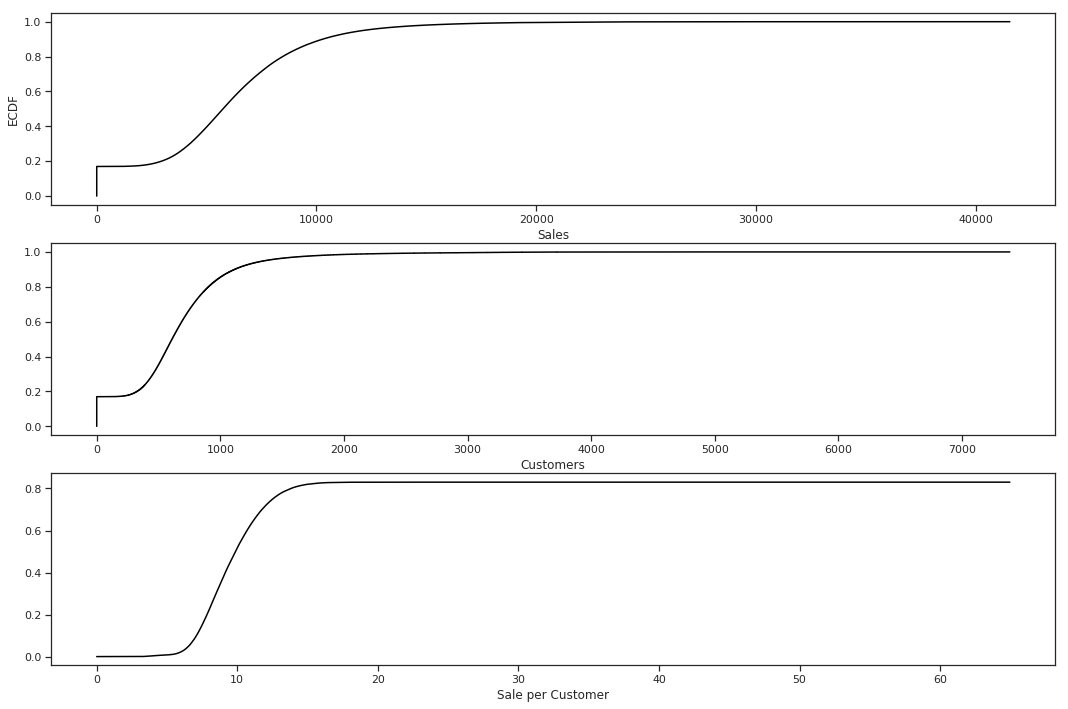

In [5]:
sns.set_context('poster')
sns.set(style = "ticks")# to format into seaborn 
c = 'black' # basic color for plots
plt.figure(figsize = (18, 12))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

<li> About 20% of data has zero amount of sales/customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

### Missing values 
#### Closed stores with zero sales

In [6]:
# closed stores
print('Number of closed stores: {0}'.format(len(train[(train.Open == 0) & (train.Sales == 0)])))

Number of closed stores: 172817


#### Open stores with zero sales

In [7]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print('Number of closed stores: {0}'.format(zero_sales.shape))
zero_sales.head(5)

Number of closed stores: (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [8]:
print("Closed stores and days with Zero sales won't be counted in the forecast.")

train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days with Zero sales won't be counted in the forecast.
In total:  (844338, 13)


#### Store Data Dictionary
- Store: a unique Id for each store
- StoreType: differentiates between 4 different store models: a, b, c, d
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance: distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
- Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [9]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### Data Wrangling
#### CompetitionDistance

In [10]:
# missing values in CompetitionDistance
len(store[pd.isnull(store['CompetitionDistance'])])

3

In [11]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

#### Promo2SinceWeek

In [12]:
# no promo = no information about the promo?
a11 = store[pd.isnull(store.Promo2SinceWeek)]
a11[a11.Promo2 != 0].shape

(0, 10)

if there's no `Promo2` then there's no information about it and can be replaced by zero. 
The same is true for `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`.

In [13]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [14]:
# Join train and store by specifying inner join to ensure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)

In total:  (844338, 22)


### Store types

Now let's examine different `StoreType` and distribution of `Sales` across them.  

In [15]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


`StoreType` B has the highest average of Sales, albeit very little data compared to other stores. <br>
Let's print an the sum of `Sales` and `Customers` to see which `StoreType` is the most popular.

In [16]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum().sort_values(by='Sales', ascending=False)

,Customers,Sales
StoreType,,
a,363541431,3165334859
d,156904995,1765392943
c,92129705,783221426
b,31465616,159231395


Clearly A, and D stores lead in terms of `Sales` and `Customers`. <br>

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


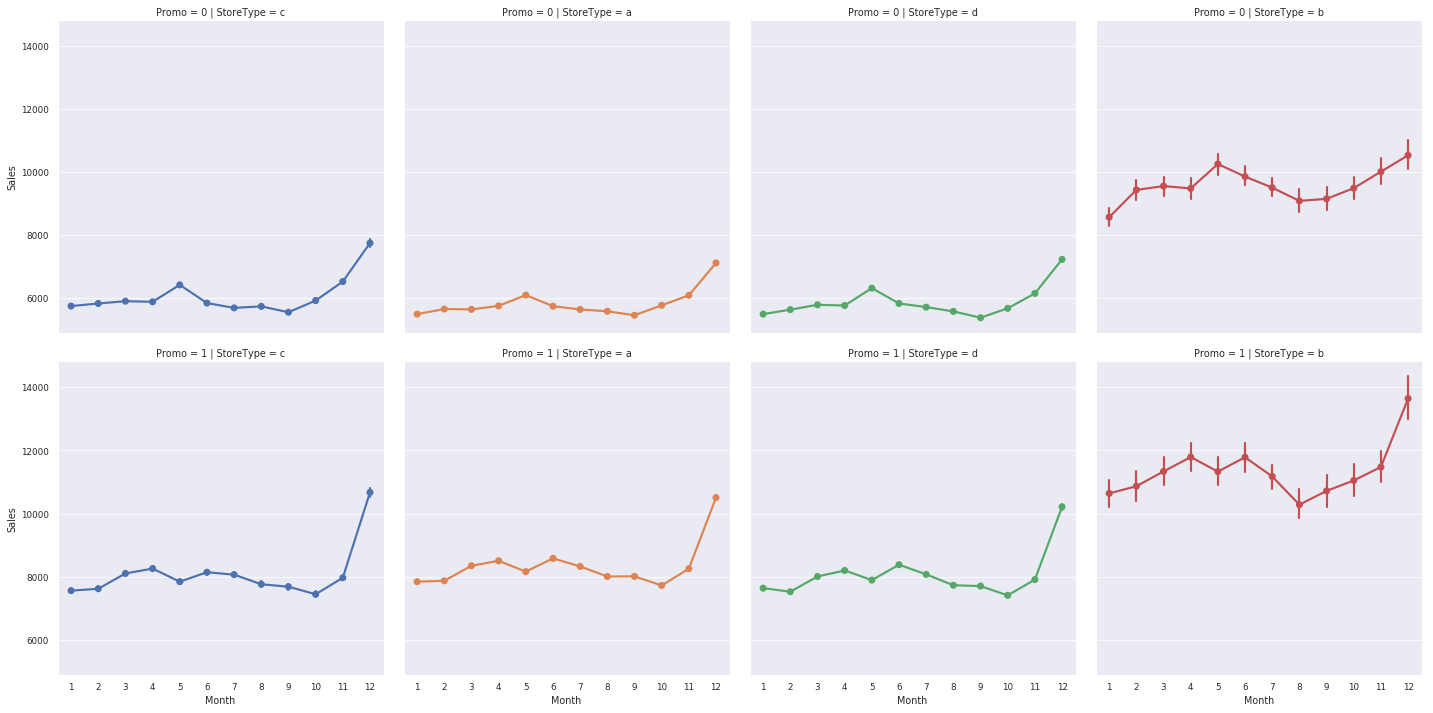

In [17]:
# sales trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


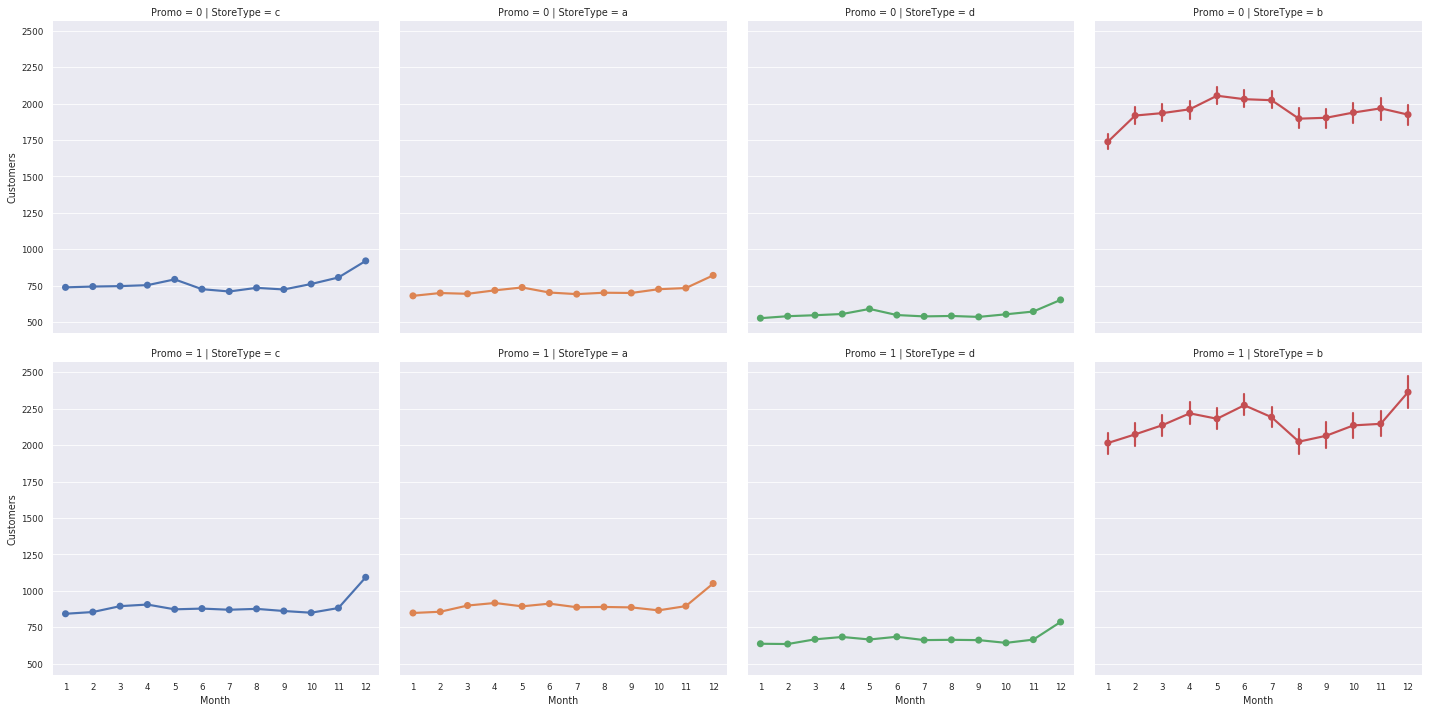

In [18]:
# customer trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

All store types follow the same trend but at different scales depending on the presence of the (first) promotion `Promo` and `StoreType` itself (case for B).

_At this point, increasing Sales towards Christmas holidays is evident, but we'll talk about seasonaliy and trends later in the Time Series Analysis section._

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


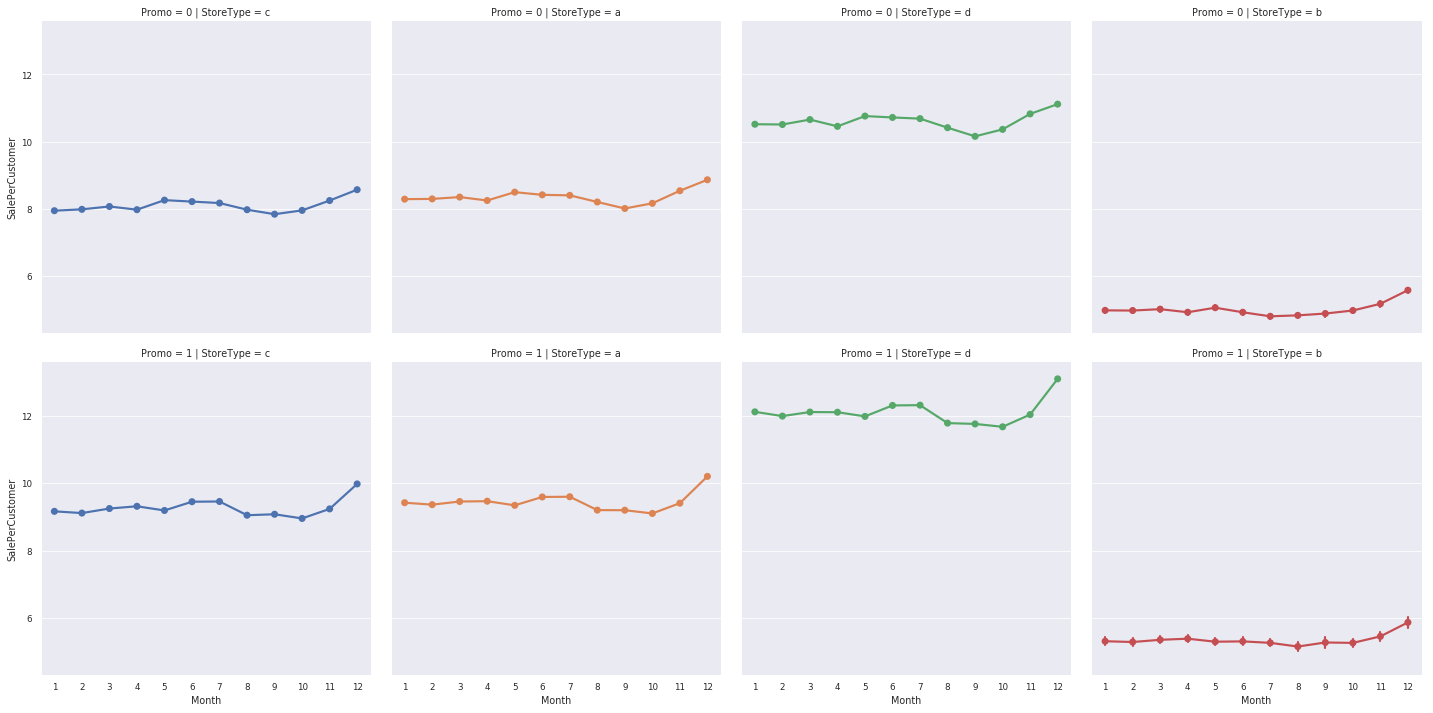

In [19]:
# sale per customer trends
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

Even though the plots above showed `StoreType` B as the most popular, though in reality that is not true. The highest `SalePerCustomer` amount is observed at the `StoreType` D, ~ 12€ with `Promo` and ~ 10€ without a promo, and for `StoreType` A and C it is about 9€. <br>
Based on low `SalePerCustomer` amount for `StoreType` B, we can attempt to describe the Cart: there are a lot of people who shop essentially for **small** things (or in a little quantity).

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


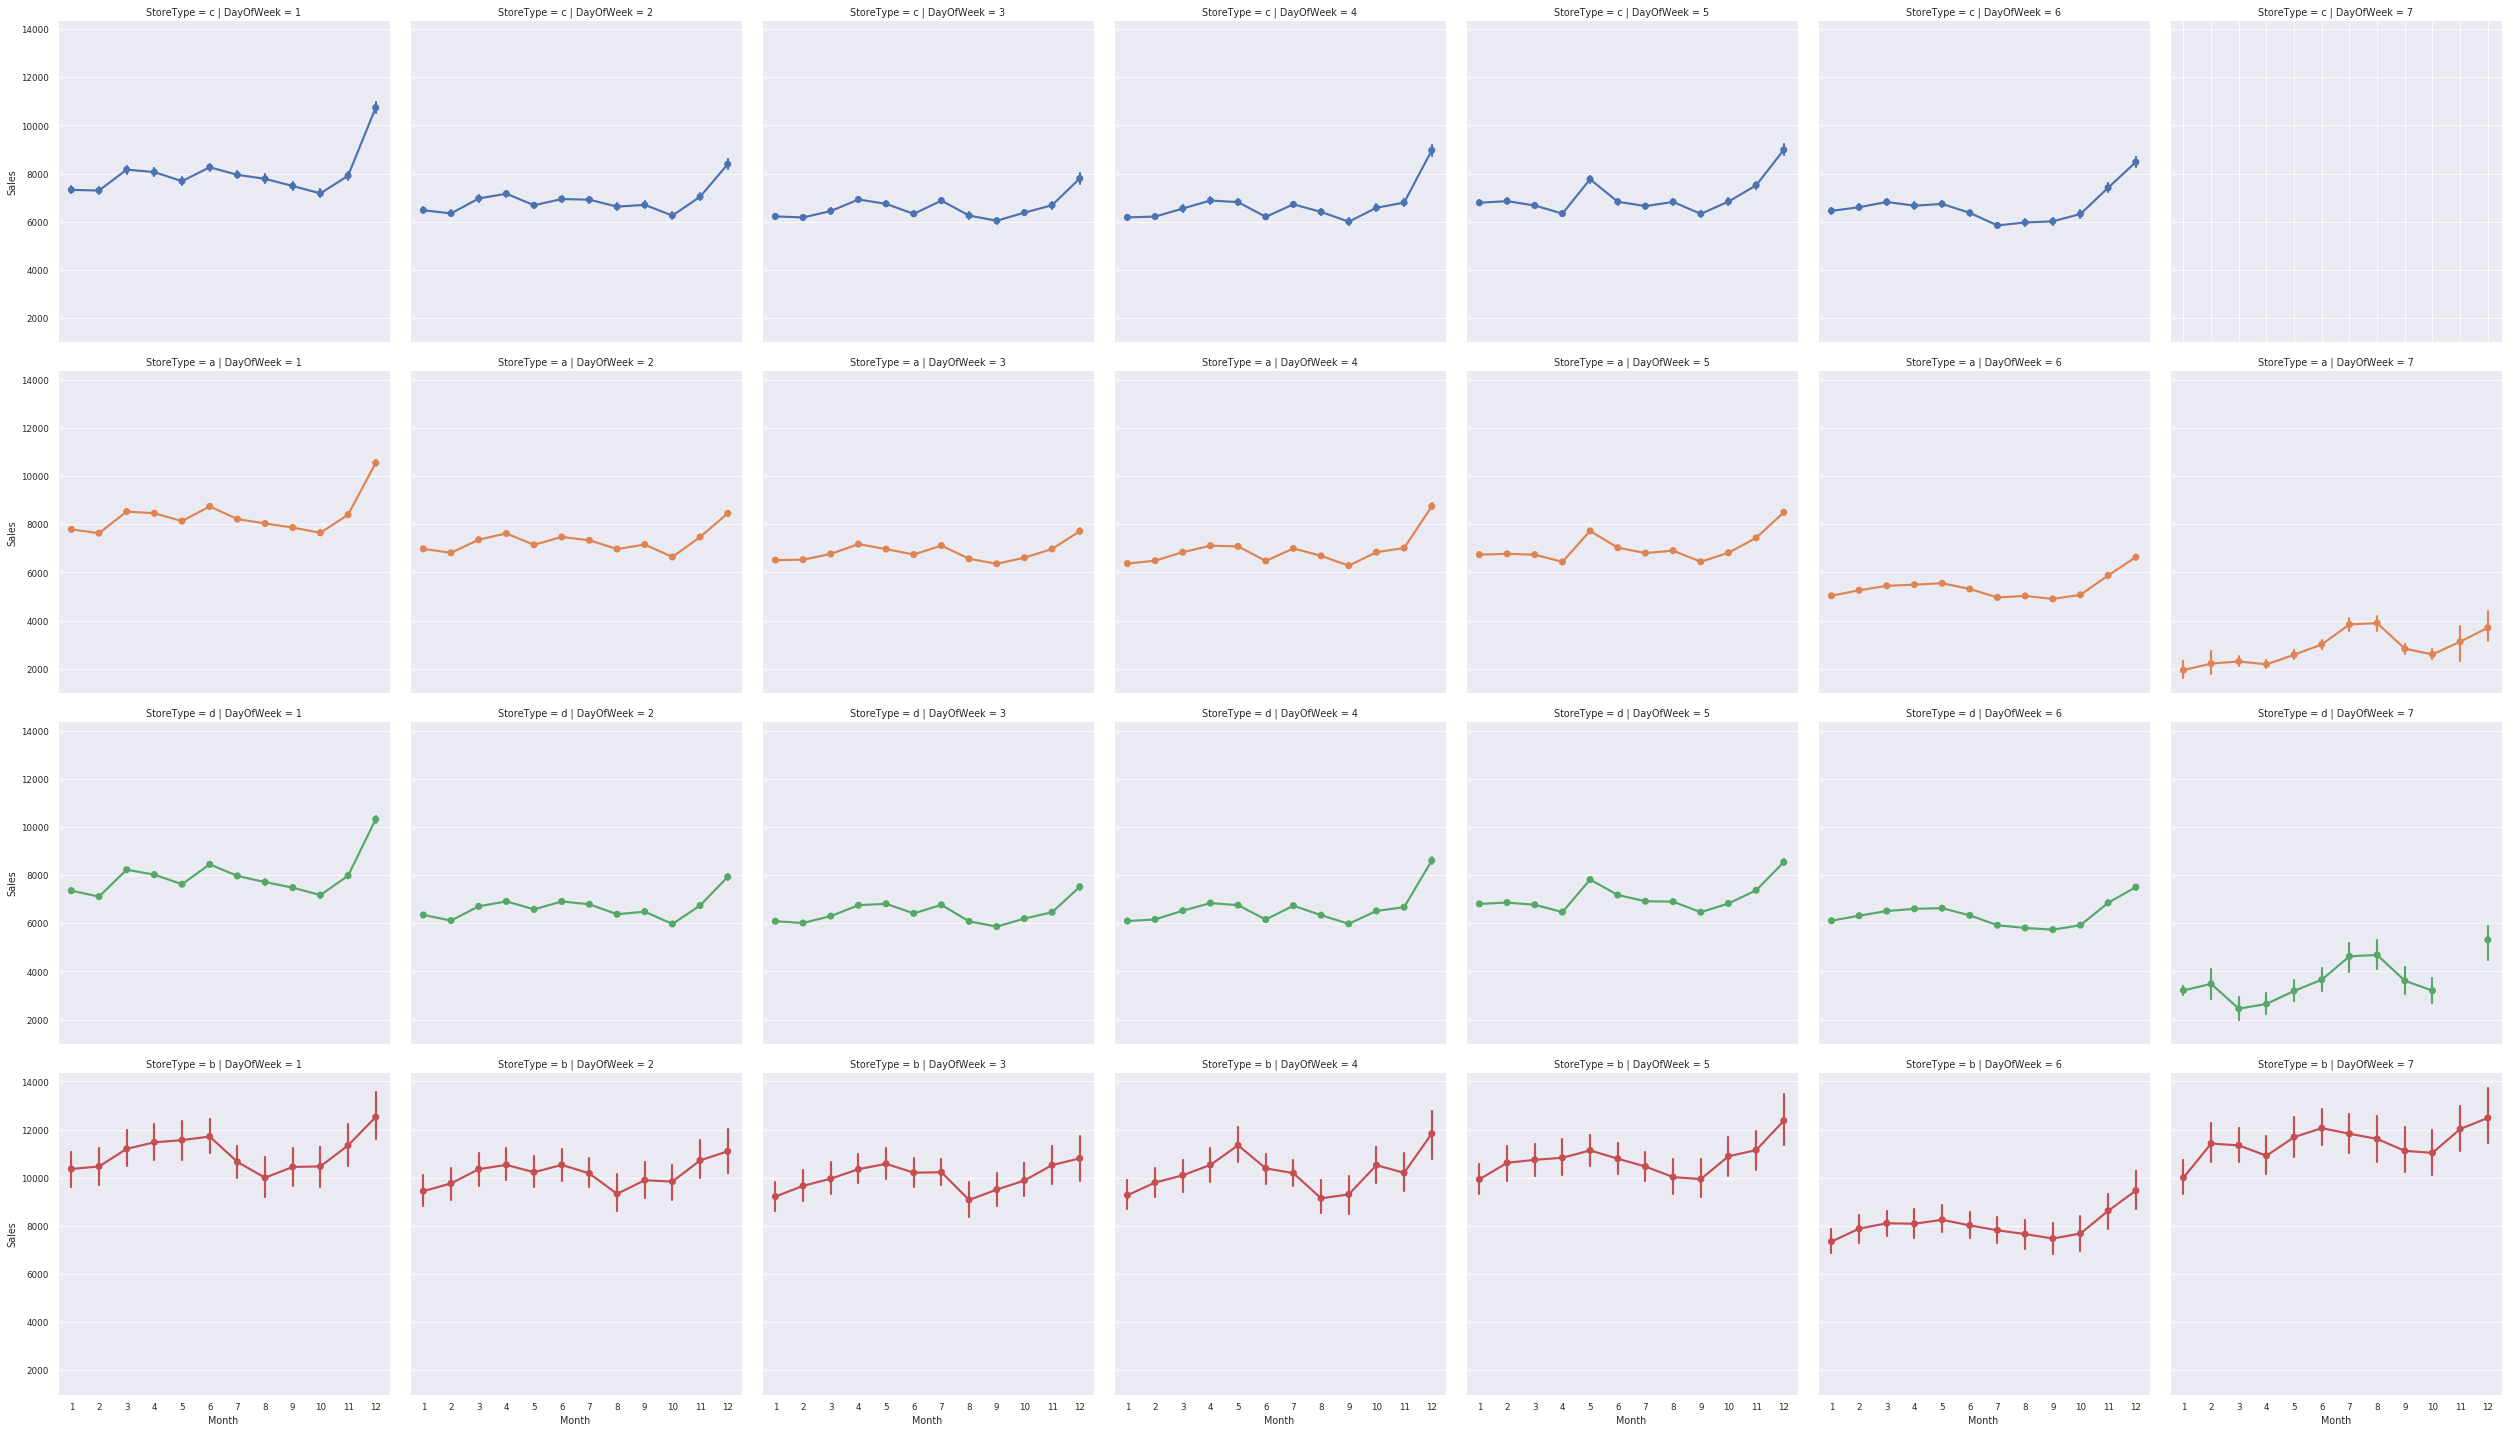

In [20]:
# customers
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'deep',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 

We see that stores of `StoreType` C are closed on Sundays, whereas others are open. Interestingly enough, stores of `StoreType` D are closed on Sundays only from October to December.

By the way which stores which are open on Sundays?

In [21]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

In [22]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean().sort_values(by='Sales', ascending=False)

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
a,6925.697986,795.422370,12918.492198,7115.514452
d,6822.300064,606.353935,10421.916846,9028.526526


`StoreType` B, has the longest running period of promotion.

### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the `seaborn` heatmap:

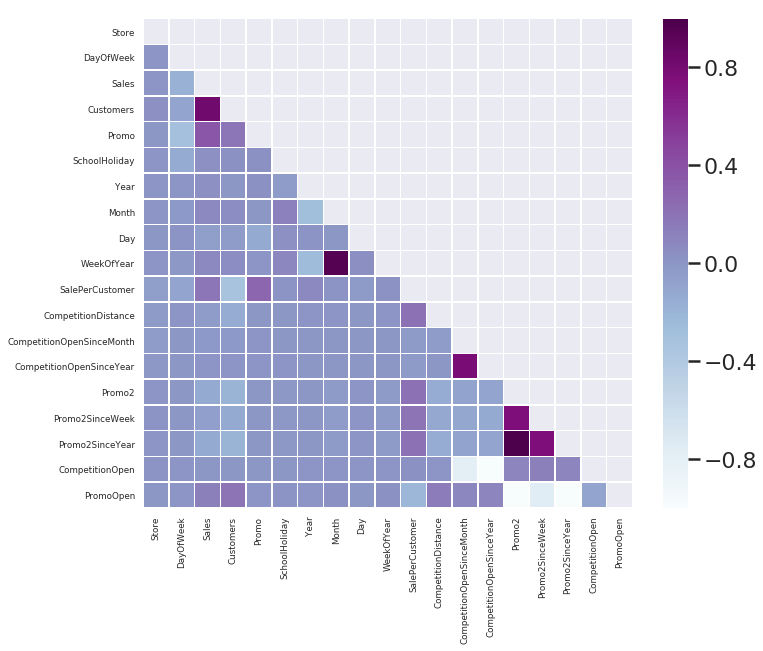

In [23]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.set_context('poster')
sns.set_style('darkgrid')
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

We can identify a positive correlation between the amount of Sales and Customers of a store.<br>
We can also observe a positive correlation between the fact that the store had a running promotion (`Promo` equal to 1) and amount of `Customers`.  <br>
Interestingly enough though, as soon as a store has consecutive promotions (`Promo2` equal to 1) the number of `Customers` and `Sales` seems to stay steady or even decrease, which is described by the pale negative correlation on the heatmap. <br>
The same negative correlation is observed between the presence of the promotion in the store and the day of a week.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


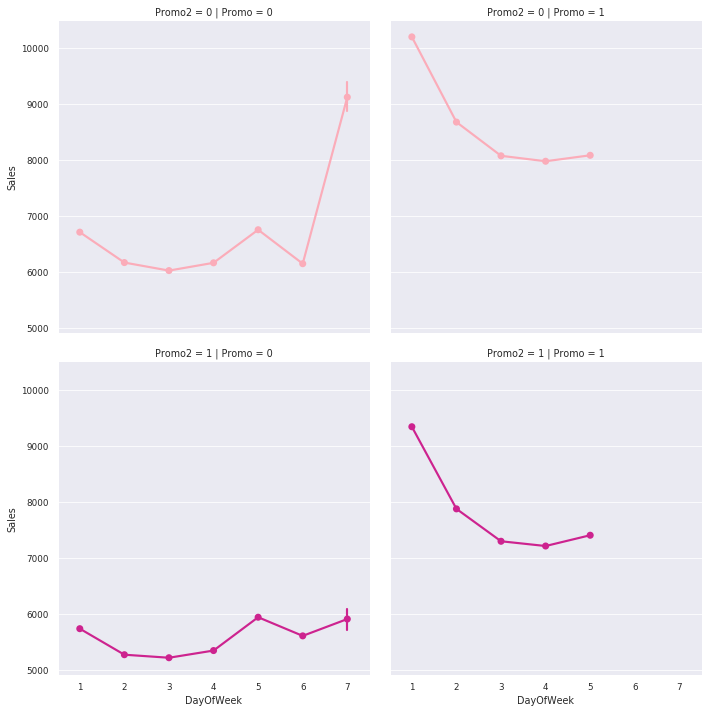

In [24]:
# sale per customer trends
sns.set_context('paper')
sns.set_style('darkgrid')
_=sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

Few things to be noted from above <br>
In case of no active promotion, both `Promo` and `Promo2` equal to 0, `Sales` tend to peak on Sunday. Though we should note that `StoreType` C doesn't work on Sundays.<br>
On the contrary, stores that run the promotion tend to make most of the `Sales` on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (`Promo` and `Promo2` are equal to 1). <br>
`Promo2` alone doesn't seem to be correlated to any significant change in the `Sales` amount. <br>

## Summary of EDA

The `StoreType` is A is most crowded with highest sales.<br>
`StoreType` D with highest "**Sale per Customer**"  indicates a strong Buyer Cart. An interesting thing to do will be to map these stores on the map to check whether they are urban or rural locations.<br>
Low `SalePerCustomer` amount for `StoreType` B alludes to the possibility that people are essentially shopping for sundry items. An interesting thing to do will be to map these stores on the map to check whether they are urban or rural locations and compare it against locations from point 2. <br>
Customers tends to buy more on Mondays when there's a single promotion running (`Promo`) and on Sundays when there is no promotion at all (both `Promo` and `Promo1` are equal to 0).<br> 

My goal is now to create a model which predicts 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation.

## Goal: Learning and Prediction of time series data using Prophet, XGBoost, and Applied Deep Learning

### Time Series Analysis and Forecasting with Prophet

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called [Prophet](https://research.fb.com/prophet-forecasting-at-scale/). It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays.

In [25]:
# importing data
df = pd.read_csv("/mnt/disks/disk-1/data/rossmann/train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [26]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


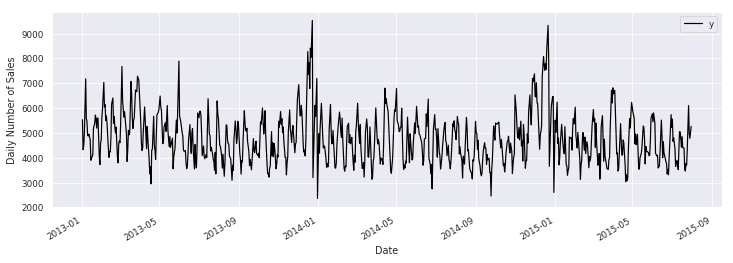

In [27]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### Modeling Holidays

Using [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html) feature in Prophet we use StateHoliday variable, at which all stores are normally closed, and SchoolHoliday variable, at which ceratin stores are closed.

In [28]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [29]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [30]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.315126,2504.291811,5752.626196
817,2015-09-06,4087.136609,2416.631739,5699.515965
818,2015-09-07,4161.901669,2501.386518,5772.358030
819,2015-09-08,3664.283500,2075.351524,5297.826932
820,2015-09-09,3551.082173,2023.334510,5151.686315
821,2015-09-10,3462.584725,1905.617192,5119.427180
822,2015-09-11,3717.252800,2151.089776,5230.186880


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [31]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

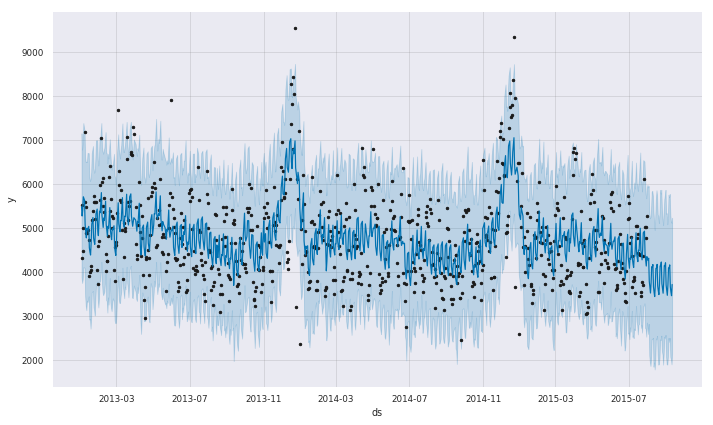

In [32]:
# visualizing predicions
my_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:

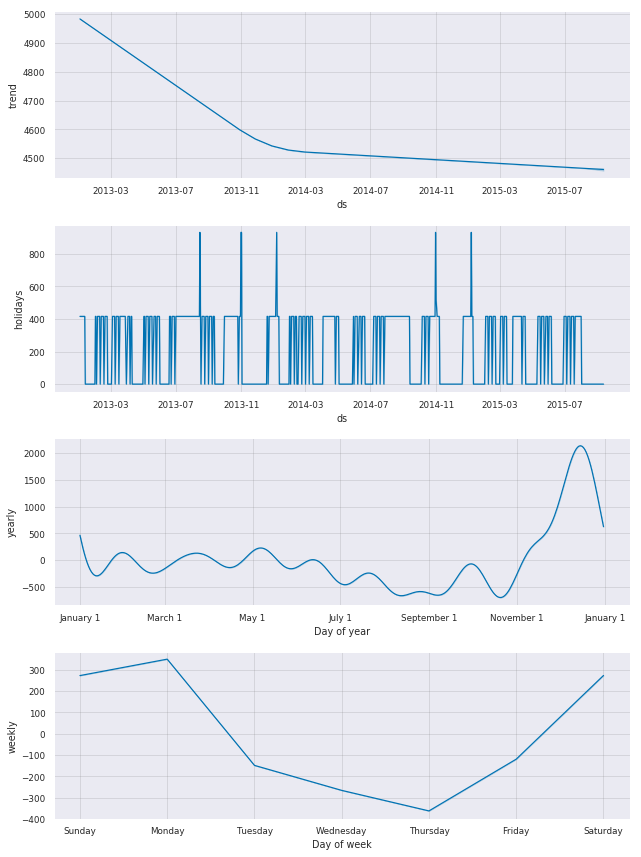

In [33]:
my_model.plot_components(forecast);

The first plot shows that the monthly sales of store number 1 has been linearly decreasing  over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.

### Recap of Time Series analysis using Prophet

In last part we demonstrated time series analysis using `.seasonal_decompose()`, `ACF` and `PCF` plots and fited forecasting model using `Prophet` by Facebook.

We can now summarize main advantages and disadvantages of using `Prophet`

__Advantages__
- Powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manualy).
- Easily implemented with R `auto.arima()` from `forecast` package, which runs a complex grid search and sophisticated algorythm behind the scene.

__Disadvantages__
- Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are `Promo` and `CompetitionOpen`. 
- Eventhough Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the the biggest drawback for new companies.
- Seasonal ARIMA in Python has 7 hyperparameters which can be tuned only manually affecting significantly the speed of the forecasting process.

### Alternative Approach: using XGBoost

In [34]:
# to predict to
test = pd.read_csv("/mnt/disks/disk-1/data/rossmann/test.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


The Id variable represents a (Store, Date) duple within the test set.

In [35]:
# test: missing values?
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [36]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


We see that these stores should be normally opened. Let's assume that they are then.

In [37]:
# replace NA's in Open variable by 1 
test.fillna(1, inplace = True)

### Data Encoding

XGBoost doesn't support anything else than numbers. So prior to modeling we need to encode certain factor variables into numerical plus extract dates as we did before for the train set.

In [38]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

train_store.Assortment.replace(mappings, inplace = True)
train_store.StoreType.replace(mappings, inplace = True)
train_store.StateHoliday.replace(mappings, inplace = True)
train_store.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

Returning back to the `train_store` data:

In [39]:
# take a look on the train and store again
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
1,1,4,5020,546,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
2,1,3,4782,523,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
3,1,2,5011,560,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
4,1,1,6102,612,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75


Let's merge `test` and `store` data too:

In [40]:
print("Joining test set with an additional store information.")
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

print("In total: ", test_store.shape)
test_store.head()

Joining test set with an additional store information.
In total:  (41088, 21)


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,1,4,1.0,1,0,0,2015,9,17,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
1,857,1,3,1.0,1,0,0,2015,9,16,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
2,1713,1,2,1.0,1,0,0,2015,9,15,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
3,2569,1,1,1.0,1,0,0,2015,9,14,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
4,3425,1,7,0.0,0,0,0,2015,9,13,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.25


### Model Training

1. Split train data to train and test set to evaluate the model.
2. Set `eta` to a relatively high value (e.g. 0.05 ~ 0.1), num_round to 300 ~ 500
3. Use grid search to find the best combination of additional parameters.
4. Lower `eta` until we reach the optimum.
5. Use the validation set as watchlist to retrain the model with the best parameters. 

In [41]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train_store.columns if x not in ['Customers', 'Sales', 'SalePerCustomer']]
y = np.log(train_store.Sales) # log transformation of Sales
X = train_store

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [42]:
# predictors
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpen', 'PromoOpen'],
      dtype='object')

In [43]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

#### Tuning Parameters

-  `eta`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [44]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [45]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.44345	test-rmse:7.44316	train-rmspe:0.999527	test-rmspe:0.999527
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.70084	test-rmse:6.70056	train-rmspe:0.998823	test-rmspe:0.998824
[2]	train-rmse:6.03265	test-rmse:6.03231	train-rmspe:0.99755	test-rmspe:0.997551
[3]	train-rmse:5.43145	test-rmse:5.43113	train-rmspe:0.995405	test-rmspe:0.995408
[4]	train-rmse:4.89043	test-rmse:4.89013	train-rmspe:0.992014	test-rmspe:0.992018
[5]	train-rmse:4.40388	test-rmse:4.40357	train-rmspe:0.986923	test-rmspe:0.986928
[6]	train-rmse:3.96593	test-rmse:3.96565	train-rmspe:0.979708	test-rmspe:0.979713
[7]	train-rmse:3.57205	test-rmse:3.57174	train-rmspe:0.969901	test-rmspe:0.969905
[8]	train-rmse:3.21771	test-rmse:3.21743	train-rmspe:0.957136	test-rmspe:0.957136
[9]	train-rmse:2.89892	test-rmse:2.89863	train-rmspe:0.941141	test-rmspe:0.941128
[10]	train-rmse:2.61214	test-rmse:2.

Last five rows:

`
[295]	train-rmspe:0.106959	test-rmspe:0.111575
[296]	train-rmspe:0.106855	test-rmspe:0.111498
[297]	train-rmspe:0.106467	test-rmspe:0.111439
[298]	train-rmspe:0.106348	test-rmspe:0.111331
[299]	train-rmspe:0.105759	test-rmspe:0.111298
`

Essentially, we want the least value. The model with base hyperparameters gives out better result on the train set, indicating potential **overfitting**.

### Grid Search from sklearn

In [46]:
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

For parameters we will specify the regularization parameter `reg_alpha` which reduce model complexity and enhance performance, as well as `gamma` parameter which represents the minimum loss reduction required to make a split and also `max_depth` used to control over-fitting.

In [47]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:200: DeprecationWarnin

{'gamma': 0.033629748282062444, 'learning_rate': 0.24190893099159014, 'max_depth': 18, 'reg_alpha': 17.52570387054035}
0.9995348583905426


In [48]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.044338624448041611, 
    'max_depth': 16, 
    'gamma': 0.80198330585415034,
    'reg_alpha': 23.008226565535971,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.90279	test-rmse:7.90248	train-rmspe:0.999763	test-rmspe:0.999763
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:7.55323	test-rmse:7.5529	train-rmspe:0.999592	test-rmspe:0.999593
[2]	train-rmse:7.21919	test-rmse:7.21887	train-rmspe:0.999363	test-rmspe:0.999363
[3]	train-rmse:6.90001	test-rmse:6.8997	train-rmspe:0.99906	test-rmspe:0.99906
[4]	train-rmse:6.59502	test-rmse:6.5947	train-rmspe:0.998664	test-rmspe:0.998665
[5]	train-rmse:6.3036	test-rmse:6.30328	train-rmspe:0.998156	test-rmspe:0.998156
[6]	train-rmse:6.02511	test-rmse:6.02477	train-rmspe:0.99751	test-rmspe:0.997512
[7]	train-rmse:5.75901	test-rmse:5.75868	train-rmspe:0.996702	test-rmspe:0.996704
[8]	train-rmse:5.50477	test-rmse:5.50444	train-rmspe:0.9957	test-rmspe:0.995702
[9]	train-rmse:5.26189	test-rmse:5.26153	train-rmspe:0.994473	test-rmspe:0.994475
[10]	train-rmse:5.02975	test-rmse:5.02938	tr

Last five rows:
    
`
[295]	train-rmspe:0.213295	test-rmspe:0.147425
[296]	train-rmspe:0.213214	test-rmspe:0.147367
[297]	train-rmspe:0.213061	test-rmspe:0.147199
[298]	train-rmspe:0.213084	test-rmspe:0.14701
[299]	train-rmspe:0.212913	test-rmspe:0.146808
`

We dealt with overfitting, but due to the decrease of learning rate (`eta`) we got a reduced overall score on the test set (~0.11 to ~0.14).

In [49]:
yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))
error = rmspe(X_test.Sales.values, np.exp(yhat))

print('First validation yelds RMSPE: {:.6f}'.format(error))

First validation yelds RMSPE: 0.146761


Even though we observed a bit higher RMSPE value, we need to remember that the corresponding `eta` for the first version was 0.1, which is usually considered as high. I think that it's remarkable that we got more or less the same result but with 2x lower `eta` (0.1 to 0.04).

### Model understanding

Feature importance scores help us see which variables contributed the most to the score.

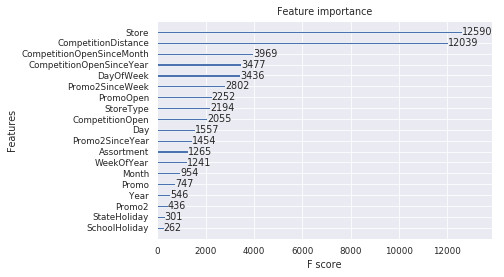

In [50]:
xgb.plot_importance(model_final)

Variables `Store` and `CompetitionDistance` are both leading. Then go features `CompetitionOpenSinceMonth`,  `CompetitionOpenSinceYear`, `DayOfWeek`, `PromoSinceWeek` and deducted features `PromoOpen`.

### Prediction on unseen data

In [51]:
# predictions to unseen data
unseen = xgb.DMatrix(test_store[predictors])
test_p = model_final.predict(unseen)

forecasts = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_p)})
# forecasts
forecasts.head()

,Id,Sales
Date,,
2015-09-17,1,4428.245117
2015-09-17,2,4577.312500
2015-09-17,3,4895.477051
2015-09-17,4,5571.978516
2015-09-17,5,4961.963379


In [52]:
# first
# 0.66419
test_base = xgb_model.predict(unseen)

forecasts_base = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_base)})
forecasts_base.to_csv("xgboost_2_submission.csv", index = False)

(array([735813., 735820., 735827., 735834., 735841., 735848., 735855.]),
 <a list of 7 Text xticklabel objects>)

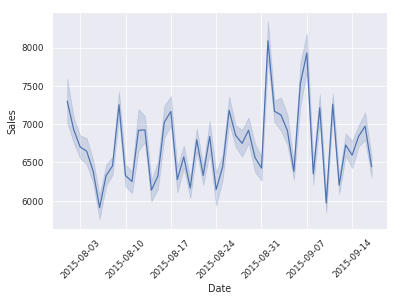

In [212]:
sns.set_style('darkgrid')
sns.set_context('paper')
_=sns.lineplot(x=forecasts_base.index, y='Sales', data=forecasts_base)
plt.xticks(rotation=45)

In [53]:
# final
# 0.60553
forecasts.to_csv("xgboost_submission.csv", index = False) 

## Using FastAI libraries for Deep Learning on Tabular data
### Create datasets

In [62]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='/mnt/disks/disk-1/data/rossmann/'

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [63]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [64]:
# concat_csvs('googletrend')
# concat_csvs('weather')

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [65]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [66]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [67]:
from IPython.display import HTML, display

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [68]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [69]:
for t in tables: display(DataFrameSummary(t).summary())

/usr/local/lib/python3.6/dist-packages/pandas_summary/__init__.py:92: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  stats.ix[columns, 'types'] = ctype


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,RheinlandPfalz,HE
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [70]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [71]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [72]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [73]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [74]:
weather = join_df(weather, state_names, "file", "StateName")

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [75]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [76]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

/usr/local/lib/python3.6/dist-packages/dateutil/parser/__init__.py:46: DeprecationWarning: _timelex is a private class and may break without warning, it will be moved and or renamed in future versions.
  warnings.warn(msg, DeprecationWarning)


The Google trends data has a special category for the whole of the Germany - we'll pull that out so we can use it explicitly.

In [77]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [78]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [79]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [80]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [81]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [82]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [83]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [84]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [85]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data.

In [86]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [87]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [88]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [89]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [90]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [91]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [92]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [93]:
#df = train[columns]
df = train[columns].append(test[columns])

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [94]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We'll do this for two more fields.

In [95]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [96]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [97]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [98]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [99]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [100]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [101]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [102]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [103]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [104]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [105]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [106]:
df.drop(columns,1,inplace=True)

In [107]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [108]:
df.to_feather(f'{PATH}df')

In [109]:
df = pd.read_feather(f'{PATH}df')

In [110]:
df["Date"] = pd.to_datetime(df.Date)

In [111]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [112]:
joined = join_df(joined, df, ['Store', 'Date'])

In [113]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [114]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [115]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [116]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

## Create features

In [117]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [118]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [119]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [120]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [121]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [122]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [123]:
apply_cats(joined_test, joined)

In [124]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

We're going to run on a sample.

In [125]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [126]:
samp_size = n
joined_samp = joined.set_index("Date")

We can now process our data...

In [127]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064


In [128]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [129]:
joined_test = joined_test.set_index("Date")

In [130]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [131]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-1.620066,0.149027,-0.142774,-1.844823,1.732492,1.724334,0.604461,1.13112,1.113717,2.04105
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-1.264031,-0.960613,-0.142774,-0.488722,1.294578,1.724334,0.926957,1.13112,1.113717,2.04105


In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [132]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [133]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [134]:
val_idx=[0]

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric we will use

In [135]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [136]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [137]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [138]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [139]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [140]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [141]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [142]:
#m.summary() 

In [143]:
lr = 1e-3
m.lr_find()

 60%|█████▉    | 3927/6597 [01:55<01:18, 33.99it/s, loss=0.113]

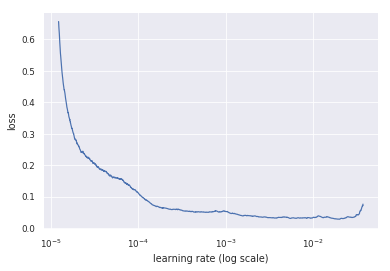

In [144]:
m.sched.plot(100)

### Sample

In [145]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [146]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.013859   0.007972   0.093396  
    1      0.010903   0.001644   0.039738  
    2      0.009677   0.001863   0.044109  


[array([0.00186]), 0.044109333760491906]

In [147]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.007408   7.7e-05    0.008808  
    1      0.007176   0.000366   0.018941  
    2      0.006819   0.000531   0.022786  
    3      0.006594   0.000157   0.012448  
    4      0.007049   0.000192   0.013762  


[array([0.00019]), 0.013762329696364407]

In [148]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.007205   0.000353   0.018972  
    1      0.00697    9e-06      0.003062  
    2      0.006211   0.000673   0.025606  
    3      0.006319   0.001497   0.037953  
    4      0.009319   0.006759   0.078925  
    5      0.006643   0.001568   0.03882   
    6      0.005298   0.001327   0.035773  
    7      0.005945   0.001161   0.033502  


[array([0.00116]), 0.033501673044699566]

### All

In [149]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [150]:
m.fit(lr, 1, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.013604   0.009471   0.102209  


[array([0.00947]), 0.10220941051306773]

In [151]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.010796   0.009266   0.091772  
    1      0.009377   0.00053    0.022753  
    2      0.009234   0.001257   0.03483   


[array([0.00126]), 0.03482994835563669]

In [152]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.007541   1e-06      0.000913  
    1      0.006914   0.0        0.000431  
    2      0.007001   0.000144   0.01208   


[array([0.00014]), 0.012080111518010372]

### Test

In [153]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [154]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.013743   0.000114   0.010603  
    1      0.01139    0.000765   0.027282  
    2      0.009932   0.001826   0.041828  


[array([0.00183]), 0.04182843087762805]

In [155]:
m.fit(lr, 3, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe  
    0      0.007377   0.000597   0.024145  
    1      0.007731   0.000526   0.023211  
    2      0.006814   0.001442   0.038703  


[array([0.00144]), 0.038702615286982364]

In [156]:
m.save('val0')

In [157]:
m.load('val0')

In [158]:
x,y=m.predict_with_targs()

In [159]:
exp_rmspe(x,y)

0.038702615286982364

In [160]:
pred_test=m.predict(True)

In [161]:
pred_test = np.exp(pred_test)

In [162]:
joined_test['Sales']=pred_test

In [213]:
joined_test.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales,Id
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,2015,9,17,False,24,0,c,a,...,14.0,6.0,69.0,67.0,105.0,0.0,1.0,0.0,4329.172852,1
2015-09-17,3,4,2015,9,17,False,24,25,a,a,...,26.0,6.0,68.0,67.0,105.0,0.0,1.0,0.0,6821.080078,2
2015-09-17,7,4,2015,9,17,False,24,0,a,c,...,14.0,5.0,59.0,67.0,115.0,0.0,1.0,0.0,9298.368164,3
2015-09-17,8,4,2015,9,17,False,11,0,a,a,...,14.0,5.0,59.0,67.0,115.0,0.0,1.0,0.0,6652.396484,4
2015-09-17,9,4,2015,9,17,False,24,0,a,c,...,26.0,6.0,68.0,67.0,105.0,0.0,1.0,0.0,7205.980469,5


## RF

In [166]:
from sklearn.ensemble import RandomForestRegressor

In [167]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [168]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [169]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.9825751372036499, 0.0, 0.9260912509570574, 0.08346625483525645)